# Load the data

In [2]:
import pandas as pd
import pickle
import math



In [3]:
data_dir = "../../../data/"
def save_obj(obj, name ):
    with open( name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(data_dir + name + '.pkl', 'rb') as f:
        return pickle.load(f)
# load data
# Edges = load_obj("New_Edges")
# Nodes = load_obj("New_Nodes")
# dict
# feature_Name = ["Number of neighbours", "Log(Num of nei)", "list of Neighbours", "list of in neighbous", 
#                 "number of in_nei", "list of out neig", "num of out neig"]
BasicFeatures = load_obj("pre_features-v2")

In [ ]:
from tqdm import tqdm
with open(data_dir + "test-public.txt", "r") as f:
     test_data = f.readlines()
test_data = [i.split() for i in test_data[1:]]
    
def predict():
    """
    make the prediction using the jaccard's coefficient
    """
    result = []
    for line in tqdm(test_data):
        # converse to integer
        node_x = int(line[1].strip())
        node_y = int(line[2].strip())
        score = get_resource_allocation(node_x, node_y)
#         print(score)
        result.append((line[0], score))
#         print(result)
    return result
result = predict()

In [13]:
def get_jaccard_coefficient(source, sink):
    """
    in: source::Node object
    in: sink::Node object
    return: jaccard's cofficient::numeric
    """
    # transform
    neighbours_of_source_list = BasicFeatures[source][2]
    neighbours_of_sink_list = BasicFeatures[sink][2]
    
    neigbours_set_of_source = set(neighbours_of_source_list)
    neigbours_set_of_sink = set(neighbours_of_sink_list)
    union_neighbours = neigbours_set_of_source | neigbours_set_of_sink
    common_neighbours = neigbours_set_of_source & neigbours_set_of_sink
    if len(union_neighbours)==0:
        return 0.0
    return(len(common_neighbours)/len(union_neighbours))

def get_preferential_attachment(source, sink):
    # transform
    neighbours_of_source_list = BasicFeatures[source][2]
    neighbours_of_sink_list = BasicFeatures[sink][2]
    
    neigbours_set_of_source = set(neighbours_of_source_list)
    neigbours_set_of_sink = set(neighbours_of_sink_list)
    
    return len(neigbours_set_of_source)*len(neigbours_set_of_sink)

def get_adamic_adar(source, sink):
    # transform
    neighbours_of_source_list = BasicFeatures[source][2]
    neighbours_of_sink_list = BasicFeatures[sink][2]

    neigbours_set_of_source = set(neighbours_of_source_list)
    neigbours_set_of_sink = set(neighbours_of_sink_list)
    common_neighbours = neigbours_set_of_source & neigbours_set_of_sink
    # get the summation
    score = 0
    for common_node in common_neighbours:
        if math.log(len(BasicFeatures[common_node][2])) == 0:
            return 0.0
        score = score + 1/math.log(len(BasicFeatures[common_node][2]))
    return score

def get_resource_allocation(source, sink):
    neighbours_of_source_list = BasicFeatures[source][2]
    neighbours_of_sink_list = BasicFeatures[sink][2]
#     print(neighbours_of_source_list)
#     print(neighbours_of_sink_list)
    neigbours_set_of_source = set(neighbours_of_source_list)
    neigbours_set_of_sink = set(neighbours_of_sink_list)
    
    common_neighbours = neigbours_set_of_source & neigbours_set_of_sink
#     print(common_neighbours)
    score=0
    for common_node in common_neighbours:
        # number of the neighbours of the common_node
        try:
            single_common_node_score = 1/BasicFeatures[common_node][0]
        except:
            single_common_node_score=0
        score = score + single_common_node_score
    return score


def get_resource_allocation_v2(source, sink):
    in_neighbours_of_source_list = set(BasicFeatures[source][3])
    in_neighbours_of_sink_list = set(BasicFeatures[sink][3])

    out_neighbours_of_source_list = set(BasicFeatures[source][5])
    out_neighbours_of_sink_list = set(BasicFeatures[sink][5])

    common_neighbours_1 = out_neighbours_of_source_list & in_neighbours_of_sink_list
    common_neighbours_2 = in_neighbours_of_source_list & out_neighbours_of_sink_list
    print(common_neighbours_1)
    print(common_neighbours_2)
    score_x=0
    score_y=0
    for common_node in common_neighbours_1:
        # number of the neighbours of the common_node
        try:
            # only count the out neighobour
            single_common_node_score = 1/BasicFeatures[common_node][2]
        except:
            single_common_node_score=0
        score_x = score_x + single_common_node_score
        print()
    
    for common_node in common_neighbours_2:
        # number of the neighbours of the common_node
        try:
            # only count the out neighobour
            single_common_node_score = 1/BasicFeatures[common_node][2]
        except:
            single_common_node_score=0
        score_y = score_y + single_common_node_score
    score = score_x+score_y
    return score
    

# how similar are the outbound neighbors of source to sink
# either JA, PA, AA
def get_outbound_similarity_score(source, sink, metric):
    # get the outbound_node of source
    outbound_node_for_source_set = set(BasicFeatures[source][5])
    summation = 0
    for outbound_node_for_source in outbound_node_for_source_set:
        summation =summation + metric(sink,outbound_node_for_source)
    if len(outbound_node_for_source_set) == 0:
        return 0
    score = 1/len(outbound_node_for_source_set)*summation
    return score

# either JA, PA, AA
def get_inbound_similarity_score(source, sink, metric):
    # get the inbound_node of sink
    inbound_node_for_sink_set = set(BasicFeatures[source][3])
    summation = 0
    for inbound_node_for_sink in inbound_node_for_sink_set:
        summation =summation + metric(source,inbound_node_for_sink)
    if len(inbound_node_for_sink_set) == 0:
        return 0
    score = 1/len(inbound_node_for_sink_set)*summation
    return score


In [31]:
import random                                                                                                                               

def find_path(graph, start, end, path, max_):
        # Append to the path
        path.append(start)
        # If the end has been reached, or the length about to exceed, return
        if start == end or len(path) == max_:
            return path

        # Randomly select the next neighbor and traverse it
        find_path(graph, random.choice(graph[start]), end, path, max_)

graph = {1: [9],
    2: [10],
    3: [6, 8], 
    4: [1, 6], 
    5: [1],
    6: [7],
    7: [1, 3], 
    8: [2],
    9: [4],
    10: [3, 5]}           
start = random.randint(1,10)
end = random.randint(1,10)

path = []
find_path(graph, start, end, path, 3)        
print(start, end, path)

8 7 [8, 2, 10]


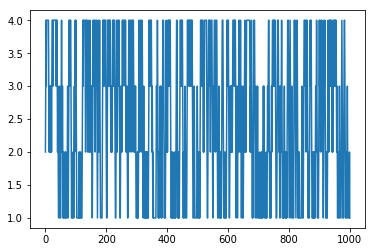

In [35]:
# Python code for 1-D random walk.
import random
import numpy as np
import matplotlib.pyplot as plt
 
# Probability to move up or down
prob = [0.5, 0.5]  
 
# statically defining the starting position
start = 2 
positions = [start]
 
# creating the random points
rr = np.random.random(1000)
downp = rr < prob[0]
upp = rr > prob[1]

for idownp, iupp in zip(downp, upp):
    down = idownp and positions[-1] > 1
    up = iupp and positions[-1] < 4
    positions.append(positions[-1] - down + up)
 
# plotting down the graph of the random walk in 1D
plt.plot(positions)
plt.show()

In [18]:
get_resource_allocation(3406737, 3781412)

[78389, 294407, 337181, 569435, 861236, 874565, 1153699, 1329067, 1341632, 1621859, 1621859, 1838999, 2277060, 2294154, 2409992, 2526116, 2855340, 2956481, 2956481, 3041643, 3100804, 3164392, 3350803, 3552924, 3706871, 3747793, 4173017, 4173602, 4196929, 4339419, 4720792, 4813929]
[610208, 2366247]
set()


0

In [14]:
from tqdm import tqdm
with open(data_dir + "test-public.txt", "r") as f:
     test_data = f.readlines()
test_data = [i.split() for i in test_data[1:]]
    
def predict():
    """
    make the prediction using the jaccard's coefficient
    """
    result = []
    for line in tqdm(test_data):
        # converse to integer
        node_x = int(line[1].strip())
        node_y = int(line[2].strip())
        score = get_resource_allocation_v2(node_x, node_y)
#         print(score)
        result.append((line[0], score))
#         print(result)
    return result
result = predict()


  4%|▍         | 78/2000 [00:00<00:04, 459.87it/s]

set()
set()
{2120801, 2809458}
set()


set()
set()
{2152768, 2307937, 2789436, 2385853}
set()




set()
{20388}
{4003975, 76360, 3103881, 2308522, 1798770, 652025, 4738810, 1869658}
{2202272, 110976, 2298370, 4003975, 76360, 3103881, 3480750, 1798770, 652025, 4738810, 1869658, 3258686}








{448823}
set()

{2108224}
set()

set()
set()
set()
set()
{1324992, 2120801, 2984603}
set()



{3973361}
set()

set()
set()
{888836}
set()

{1196225, 3061931}
set()


set()
set()
{20388}
{20388}

set()
set()
set()
set()
{2582486, 4466822}
set()


set()
set()
set()
set()
set()
set()
{3227840, 4595137, 4840928, 4575620, 1270053, 355653, 3889783, 838983, 2977223, 241708, 3008279, 3153773, 4416976, 2039665, 1801460, 3011799, 1351195, 3301341}
set()


















set()
set()
{673087, 3528927}
set()


set()
set()
{3711578, 1870509, 4518502}
set()



{4588320, 376921}
{4588320}


{4514600}
set()

set()
set()
set()
set()
{4595137, 4038935}
set()


{2658985, 2973887}
set()


set()
set()
set()
set()
set

 16%|█▌        | 318/2000 [00:00<00:02, 776.96it/s]


set()
set()
{1324992, 2120801}
set()


{1341632, 2120801, 4588320, 4096612, 1638122, 2740141, 1460816}
set()







set()
set()
set()
set()
set()
set()
set()
set()
{1341632, 2740141, 2926541, 2359631, 4840465, 448823, 2984603, 2882556, 1082205, 1413055}
{1341632, 2479008, 896422, 717002, 1638122, 426700, 2926541, 1660431, 399473, 3008915, 2420885, 487639, 2882556}










set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
{556498}
set()

{261200, 3533123, 2549365, 2740141}
set()




set()
set()
{3763337, 2810556, 2405212}
set()



{4451008, 2120801, 265346, 4502376, 4561995, 3627790, 1401429, 3655190, 2763196, 2984603, 1648028, 2255454}
set()












{1802489}
set()

{1635105, 1909985, 4265509, 4091626, 2740141, 3503374, 3926802, 2984603, 740572}
set()









{20388, 361516}
set()


set()
set()
{2809458, 20388, 4858294}
set()



{411139, 20388, 3278181, 927973, 2163240, 2740141, 2049519, 4217908, 2382007, 577496, 4434846}
set()











set()
set()
{4096612}
set()



 22%|██▎       | 450/2000 [00:00<00:01, 840.69it/s]


{2809458, 2740141, 754927}














{209191, 2644807}
{209191, 2644807}


set()
set()
{4575620}
set()

{2893396, 930661}
set()


set()
set()
set()
set()
{2785552, 3055409}
set()


{2619379, 2215646, 3267663, 2018607}
set()




{2471590, 1139433, 1870572, 1870509, 1288240, 379220, 3711578, 1413055}
{448823}








{4586866}
set()

{133673, 3711578, 3650803, 4586866}
set()




{3465568, 4306404, 4637516, 195757, 2309487, 126673, 4761107, 4790649, 1155354, 2309946}
set()










set()
set()
set()
set()
set()
set()
set()
{1145722}
set()
set()
{3011799}
set()

set()
set()
set()
set()
set()
set()
{47024}
set()

set()
set()
{741283, 1729093, 2468519, 3671943, 2367409, 760372, 4013908, 4547607, 4108731}
{2468519, 397607, 293995, 3252172, 4529388, 1258254, 760372, 4013908, 3375317, 4547607, 1190137, 4108731, 4604159}









set()
set()
{3926802, 4575620}
set()


{517122, 1817604, 2806667, 1812114, 3644308, 2970262, 1146906, 850459, 4656924, 4682788, 2969511, 3637929, 4311722, 3376555

 32%|███▏      | 644/2000 [00:00<00:01, 808.95it/s]


set()


{145219}
set()

{2998332}
set()

{2120801, 20388, 3671045, 2746983, 2930986, 1553867, 992746, 2740141, 1638122, 2309487, 451378, 3886839, 4668030}
set()













{3669864, 4302499, 4385053, 373567}
{4578211, 4302499, 3669864, 1071241, 3799178, 800457, 2657616, 4454737, 2650077, 4586866, 4385053, 2652094, 3505599}




set()
set()
set()
set()
{2894369, 3117644, 891473, 1812114, 2089396, 4840852, 1942527, 1944317, 348031}
{3539009, 4536646, 2826599, 1687276, 3117644, 1812114, 3353876, 1314168, 2089177, 1942527}









{3437795, 2862343, 2438668, 2077429, 2382007, 577496}
set()






set()
set()
set()
set()
set()
{4476596, 210398}
{4294640, 2351948, 1970637, 4233966}
{3091588, 3982057, 2351948, 1970637, 163021, 4233966, 4294640, 1929906, 1665526}




set()
set()
set()
set()
{2926541, 2880517}
set()


{4286785, 2809092, 33673, 3153773, 2309487, 3577843, 4204052, 2726331, 3550837, 2387703, 1751451, 2810556, 3247133, 4052990}
set()














{3037159, 1437899, 418892, 23895

 41%|████      | 818/2000 [00:01<00:01, 765.20it/s]


set()










{3732480, 2107915, 957452, 784910, 4840465, 2350099, 3507219, 3655190, 2326042, 3671067, 1554976, 1668129, 688693, 3253302, 2950721, 1397316, 3223627, 4561995, 4207702, 2330201, 1580634, 2120801, 2769515, 3809903, 1455727, 978544, 2809458, 1996416, 3784839, 4434064, 4397205, 3541658, 2984603, 1061533, 818849, 658596, 4309674, 1086634, 3053227, 1129136, 2898609, 1880244, 2754233, 2629112, 3393738, 3841228, 303310, 3816665, 1253081, 2793691, 572123, 2332893, 164065, 34017, 2014945, 1599720, 3185900, 5356, 132844, 1594099, 1920244, 36596, 955638, 4787959, 1572097, 3393796, 1355524, 1221894, 547593, 3627790, 554768, 4813076, 3793690, 2768159, 2293540, 4472613, 1962278, 2156336, 679732, 2057013, 331574, 977209, 4103481, 770373, 3136840, 1980745, 2152778, 3105614, 300374, 4687195, 4262760, 3451243, 4261228, 3087727, 1954674, 4586866, 848757, 2631035, 2284926, 2324352, 806785, 3573637, 816015, 775571, 3065239, 1169816, 1648028, 3670434, 2363814, 274343, 1414057, 2880938, 8897

 50%|█████     | 1001/2000 [00:01<00:01, 784.50it/s]


set()
{3503374, 2984603, 3247133, 1635105, 2757027, 4265509, 745007, 2939315, 448823, 2726331, 145219, 488518, 262985, 376921, 4687195, 3465568, 1909985, 2120801, 1638122, 2809458, 2619379, 1165817, 2333306, 4668030}
set()
























{2293540, 487236, 247783, 1660431, 3377456, 1105521, 487639, 315961}
set()








{145219}
set()

{621120, 4092666, 2735476, 126887}
{621120}




{1005221, 4583463, 4750798, 457555, 2902003, 4058550, 2845273}
{20388, 1005221, 4583463, 230446, 4750798, 261200, 457555, 2902003, 4058550, 1878814}







{3733752}
set()

{3133826, 2809092, 4575620, 3208454, 2610697, 3503374, 912016, 4332049, 378641, 4761107, 4204052, 3224468, 3978620, 4651416, 1155354, 1835930, 2528284, 3247133, 1675037, 3173026, 2680868, 4265509, 4567466, 745007, 714035, 4082872, 3610552, 884795, 99644, 2177982, 3227840, 4390465, 3111617, 2956481, 4595137, 2695621, 216902, 838983, 262985, 943306, 126673, 3824346, 2752092, 3303132, 740572, 438367, 704225, 1909985, 1875708, 24333

 59%|█████▊    | 1174/2000 [00:01<00:01, 780.53it/s]

set()
set()
{3692761, 2714965, 3050649, 1171770, 591326}
set()





{1458564, 2809092, 126344, 1385994, 3503374, 1660431, 4639252, 4265509, 215474, 2726331, 4668030, 3147352, 376921, 3471710, 3465568, 2120801, 2689774, 2809458, 1674358, 2127480, 3978620, 911998}
set()






















set()
set()
set()
set()
{4751012, 378508}
set()


set()
set()
{2984603}
set()

set()
set()
{4021250, 35842, 110612, 506389, 4204052, 865815, 850459, 2054173, 537629, 3247133, 4265509, 1440298, 3109419, 241708, 4449837, 745007, 760372, 2288696, 884795, 2056253, 1451581, 4208704, 4625985, 2436687, 68695, 2120801, 2809458, 3889783, 1812114, 2984603, 273571, 12467, 2314931, 704225, 4091626, 1638122, 1132780, 1687276, 1801460, 3746046, 3174668, 3503374, 2958606, 3926802, 262930, 3895062, 1793311, 3377440, 1635105, 3314478, 714035, 3521843, 3378483, 145219, 1860938, 1971020, 2742606, 3144014, 340818, 457555, 2596182, 1896283, 2405212, 3701608, 2309487, 2287992, 4575620, 126344, 2073992, 2806667, 2060695, 4

 68%|██████▊   | 1366/2000 [00:01<00:00, 757.28it/s]

{448823}
{3465568, 448823}

set()
set()
{20388}
set()

set()
set()
{4208704, 1216160, 2634469, 296616, 4696690, 4198133, 1674358, 2400247, 2124735, 582943}
set()










{2120801, 1759271}
{2120801, 20388}


{1763327}
set()

set()
set()
{4294721, 4389575, 547021, 3354830, 2659983, 4394459, 2810556}
set()







{2757027}
set()

{2809458, 3507219}
set()


{1324992, 2740141}
set()


set()
set()
set()
set()
{4330304, 279329, 3209795, 2824613, 4144552, 601449, 4177743, 4238322, 1860051, 3529653, 3549013, 4610775, 4745753, 810555}
{4330304, 3209795, 2824613, 4144552, 190987, 4177743, 3549013, 4610775, 4745753, 810555}














{92481, 1642114, 971074, 3079270, 3875143, 3456296, 4658663, 1142758, 2926541, 4180465, 1481047, 3177976, 748601, 3995418, 2116957, 2777919}
{92481, 1143970, 971074, 4658663, 1704012, 2926541, 4716078, 4180465, 3177976, 748601, 3995418}
















set()
set()
{2296091, 4472613}
set()


set()
set()
{2654094}
set()

{20388}
set()

{760372}
set()

set()
set()

 75%|███████▌  | 1507/2000 [00:01<00:00, 791.52it/s]


set()
{1298207}
set()
set()
set()
set()
{2178285, 2018607}
set()


set()
set()
{1039233, 1140548, 20388, 4678822, 247783, 230446, 487639, 4736574}
set()








{2122753, 332418, 768770, 2651652, 2806667, 4050188, 1812114, 3353876, 2371483, 1840412, 4238620, 2323997, 3116573, 2966560, 448545, 4445347, 1998627, 1364265, 3958825, 990399, 1729215, 3539009, 4167373, 524494, 709848, 2860635, 1996512, 3233131, 1687276, 291319, 4136953, 4187899, 4052990}
set()

































{4525472, 3463332, 585573, 2430054, 4402986, 4192587, 176620, 800650, 2966259, 4327572, 4291481, 3021179, 2861149}
{4525472, 585573, 2430054, 4402986, 4192587, 4291481, 3021179, 2364188, 2861149}













set()
set()
set()
set()
set()
set()
set()
set()
{504848, 3431594, 3116573}
set()



{3800512, 1638122, 4440363, 4768618, 3962638, 1708627, 144054, 1200055, 3769114, 4377596, 265533, 2656542}
set()












{2293540, 2200421, 3385797, 1599720, 4201419, 367245, 2740141, 534480, 775571, 688693, 243

 84%|████████▍ | 1679/2000 [00:02<00:00, 758.44it/s]


{1324992, 2951616, 4257316, 4214149, 2704231, 661704, 3434251, 2387703, 534480, 1312978, 4217908, 4208957, 543159, 1988566, 1074491, 3523229, 999647}










{2661137, 3356514}
set()


{1765731, 1888332, 3537262, 4813076, 1764694, 1998234}
set()






set()
set()
{1856737, 1966539, 132134, 24523}
{1856737, 132134, 600554, 1966539, 24523, 4254706, 2518490}




{1324992}
set()

{1311163, 1564470, 2783695}
set()



set()
set()
{3942863}
set()

set()
set()
set()
set()
set()
set()
{1324992, 20388, 1306918, 2740141, 448823, 684506}
set()






set()
set()
set()
set()
{2783695}
{1139433}

{4762625, 4401601, 745635, 618151, 2420104, 2675881, 1283657, 2932236, 559732, 2997173, 348855, 4052824, 3486938, 2171358, 1466687}
{4762625, 3016838, 2420104, 2675881, 2997521, 559732, 3486938}















{4208704, 2776192, 888836, 717002, 2350099, 1165817, 2984603, 2332893}
set()








{2725737, 3449446}
set()


{2452371}
set()

{768770, 53634, 2651652, 2809092, 4321162, 2806667, 62861, 378641, 21

 94%|█████████▍| 1878/2000 [00:02<00:00, 774.75it/s]


{3162560, 1865592, 4805254}
set()



{4767918, 2387703, 1682648, 2518746, 2984603, 3050428, 3247133}
set()







{2122753, 53634, 2685283, 4146791, 2135370, 848620, 163021, 4669839, 1802489}
{2122753, 53634, 2685283, 2135370, 848620, 3000657, 2953525, 1802489}









{3465568, 572638, 2528642, 145219, 4121411, 2648701, 1948200, 2246539, 3840652, 1930892, 4637516, 2386285, 3400944, 1904054, 922614, 2726331, 987645, 2933438, 320223}
set()



















{2343422}
set()

set()
set()
{2120801, 2984603, 3278181}
set()



set()
set()
{3086729, 2250707, 3259572}
set()



set()
set()
{3227840, 1909985, 1389250, 2120801, 262985, 2930986, 2740141, 381487, 2752092}
set()









{1375129, 2281380}
{1375129, 4502509}


{488518, 62861, 2939315, 4333556, 4442230, 2810556}
set()






set()
set()
{2740141}
set()

{1092928, 1375391, 127619, 932451, 696805, 4486224, 2141424, 2301239, 3847967}
{1092928, 127619, 932451, 2041956, 2553285, 2289353, 335946, 1586255, 3770256, 4486224, 2301239, 38479

100%|██████████| 2000/2000 [00:02<00:00, 786.80it/s]

















{2861284, 4005669, 2163240, 1841768, 2044305, 1183417, 2935547, 3912764, 1133307}
{20388}









{4169857, 3296259, 1341576, 2842633, 1610379, 3216781, 3912593, 671895, 3217561, 305951, 4050341, 2468519, 2466089, 4588969, 1851824, 3232049, 1151673, 1345338, 4108731, 4041024, 4553412, 4673348, 2206024, 3252172, 4720208, 1588061, 2225634, 1644258, 3815399, 2471400, 3552495, 4093168, 2175599, 1239673}
{4169857, 3296259, 2842633, 3912593, 671895, 3217561, 305951, 4050341, 2468519, 2466089, 4588969, 1851824, 3232049, 1151673, 1345338, 4108731, 4041024, 4553412, 4673348, 485828, 2206024, 3252172, 4720208, 1588061, 1644258, 3815399, 2471400, 2175599, 4093168, 1768567, 1239673}


































{589699, 3894541, 4830225, 2848407, 248727, 361367, 2816537, 4446498, 947246, 1620145, 3871155, 2857848, 3910584, 2481722, 2136000, 2681679, 2728019, 3137492, 2800603, 3129186, 664171, 3804269, 2020852, 3478264, 2588926}
{589699, 3894541, 4830225, 2848407, 361367, 2487

In [12]:
result

[('1', 0),
 ('2', 0),
 ('3', 0),
 ('4', 0),
 ('5', 0),
 ('6', 0),
 ('7', 0),
 ('8', 0),
 ('9', 0),
 ('10', 0),
 ('11', 0),
 ('12', 0),
 ('13', 0),
 ('14', 0),
 ('15', 0),
 ('16', 0),
 ('17', 0),
 ('18', 0),
 ('19', 0),
 ('20', 0),
 ('21', 0),
 ('22', 0),
 ('23', 0),
 ('24', 0),
 ('25', 0),
 ('26', 0),
 ('27', 0),
 ('28', 0),
 ('29', 0),
 ('30', 0),
 ('31', 0),
 ('32', 0),
 ('33', 0),
 ('34', 0),
 ('35', 0),
 ('36', 0),
 ('37', 0),
 ('38', 0),
 ('39', 0),
 ('40', 0),
 ('41', 0),
 ('42', 0),
 ('43', 0),
 ('44', 0),
 ('45', 0),
 ('46', 0),
 ('47', 0),
 ('48', 0),
 ('49', 0),
 ('50', 0),
 ('51', 0),
 ('52', 0),
 ('53', 0),
 ('54', 0),
 ('55', 0),
 ('56', 0),
 ('57', 0),
 ('58', 0),
 ('59', 0),
 ('60', 0),
 ('61', 0),
 ('62', 0),
 ('63', 0),
 ('64', 0),
 ('65', 0),
 ('66', 0),
 ('67', 0),
 ('68', 0),
 ('69', 0),
 ('70', 0),
 ('71', 0),
 ('72', 0),
 ('73', 0),
 ('74', 0),
 ('75', 0),
 ('76', 0),
 ('77', 0),
 ('78', 0),
 ('79', 0),
 ('80', 0),
 ('81', 0),
 ('82', 0),
 ('83', 0),
 ('84', 0),
 

# Explantory

# Modelling

# Please save the training set as the csv file.

In [7]:
import csv
import time
'''
Description: get time
Input: 
Output: time
''' 
def nowtime():
    return time.strftime("%Y%m%d-%H%M", time.localtime())


"""
Description: Save prediction result to files
Input: (1) result
       (2) filename
Output: 
"""
def save_prediction_to_csv(result,filename):
    headers = ['id','Prediction']

    with open(filename + str(nowtime()) + ".csv", 'w', encoding = 'utf8') as f:
        f_csv = csv.writer(f)
        f_csv.writerow(headers)
        f_csv.writerows(result)
save_prediction_to_csv(result, "shawn_ra_v2")

In [8]:
print(result)

[('1', 0), ('2', 0), ('3', 0), ('4', 0), ('5', 0), ('6', 0), ('7', 0), ('8', 0), ('9', 0), ('10', 0), ('11', 0), ('12', 0), ('13', 0), ('14', 0), ('15', 0), ('16', 0), ('17', 0), ('18', 0), ('19', 0), ('20', 0), ('21', 0), ('22', 0), ('23', 0), ('24', 0), ('25', 0), ('26', 0), ('27', 0), ('28', 0), ('29', 0), ('30', 0), ('31', 0), ('32', 0), ('33', 0), ('34', 0), ('35', 0), ('36', 0), ('37', 0), ('38', 0), ('39', 0), ('40', 0), ('41', 0), ('42', 0), ('43', 0), ('44', 0), ('45', 0), ('46', 0), ('47', 0), ('48', 0), ('49', 0), ('50', 0), ('51', 0), ('52', 0), ('53', 0), ('54', 0), ('55', 0), ('56', 0), ('57', 0), ('58', 0), ('59', 0), ('60', 0), ('61', 0), ('62', 0), ('63', 0), ('64', 0), ('65', 0), ('66', 0), ('67', 0), ('68', 0), ('69', 0), ('70', 0), ('71', 0), ('72', 0), ('73', 0), ('74', 0), ('75', 0), ('76', 0), ('77', 0), ('78', 0), ('79', 0), ('80', 0), ('81', 0), ('82', 0), ('83', 0), ('84', 0), ('85', 0), ('86', 0), ('87', 0), ('88', 0), ('89', 0), ('90', 0), ('91', 0), ('92', 

In [ ]:

filename='final_edges'
final_edges = load_obj(filename)


In [ ]:
len(final_edges)

# Prediction